## Загрузка и обзор данных

Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

Посмотрим на данные перед исследованием

In [2]:
df = pd.read_csv('/content/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Описание данных:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков - нет, все данные - численного типа. Всегда бы так, давали готовые таблицы для работы =) 

Так как задача сводится к классификации, то столбец `is_ultra` будет являться целевым признаком.

## Разбиение на подвыборки

Разобьем данную выборку на три части: тренировочную (60%), валидационную (20%) и тестовую (20%).

In [5]:
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=101)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=101)

Проверка

In [6]:
display(df_train.shape)
display(df_valid.shape)
display(df_test.shape)

(1928, 5)

(643, 5)

(643, 5)

Данные для обучения

In [7]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

Данные для валидации

In [8]:
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

Данные для тестирования

In [9]:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

## Исследуем различные модели

Исследуем четыре вида классификаторов (два рассмотрим факультативно), посмотрим как изменение гиперпараметров влияет на значение точности предсказаний моделей.

### Случайный лес

Random forest (с англ. — «случайный лес») — алгоритм машинного обучения, заключающийся в использовании комитета (ансамбля) решающих деревьев. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.

Имортируем необходимый алгоритм обучения и в цикле посмотрим сохраним все значения меткрики accuracy для разного количества деревьев для разных критериев. Далее на графиках посмотрим при каком значении будет лучший результат.

In [10]:
def random_forest(range_est,criteria):
    models = []
    results = []
    for est in range(1, range_est):
        randfor = RandomForestClassifier(random_state=101, n_estimators=est, criterion=criteria) # задаем количество деревьев
        randfor.fit(features_train, target_train) # обучаем модель на тренировочных данных
        result = randfor.score(features_valid, target_valid) # качество модели на валидационных данных
        models.append(randfor)
        results.append(result)
    results = pd.DataFrame(results, columns=['accuracy']) #Преобразуем results в таблицу для удобства построения графика
    results['number_trees'] = range(1, range_est)
    return results

Построим график для критерия **gini**

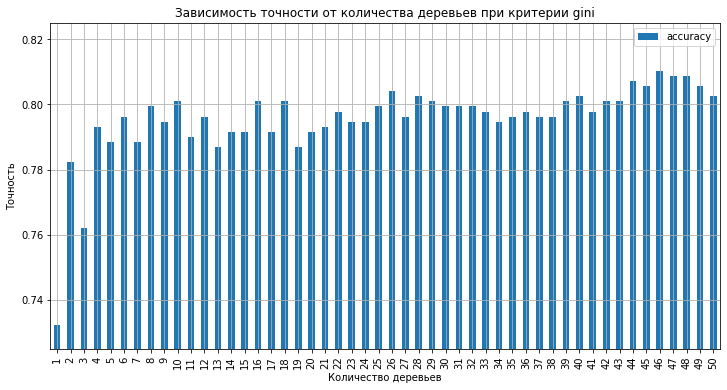

In [11]:
gini = random_forest(51,'gini')
gini.plot(kind='bar', y='accuracy', x='number_trees', ylim=[0.725,0.825], figsize=(12,6))
plt.title('Зависимость точности от количества деревьев при критерии gini')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.grid()
plt.show()

Построим график для критерия **entropy**

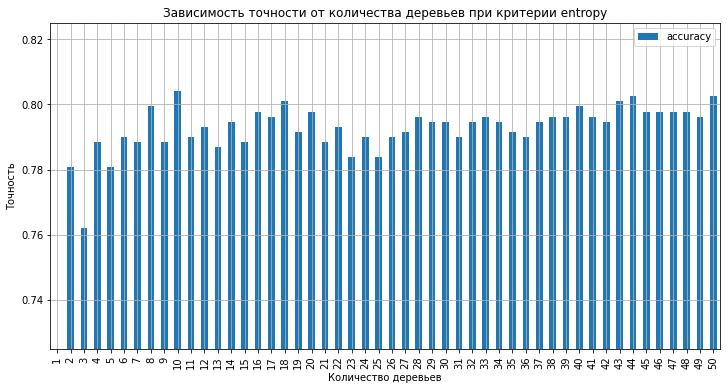

In [12]:
entropy = random_forest(51,'entropy')
entropy.plot(kind='bar', y='accuracy', x='number_trees', ylim=[0.725,0.825], figsize=(12,6))
plt.title('Зависимость точности от количества деревьев при критерии entropy')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.grid()
plt.show()

Как видно из графиков максимальная точность достигается при количестве деревьев равным **10** для критерия **entropy**, и для критерия **gini** деревьев нужно **46** для достижения максимального значения точности. Возьмем для проверки на тестовой выборке модель, показавшую лучшее значение. Значения точности занесем в таблицу. 

In [13]:
result_df = pd.DataFrame(columns=['name_ml','accuracy_valid'])

In [14]:
result_df.loc[0]=['RandomForest', gini['accuracy'].max()]

In [15]:
result_df

,name_ml,accuracy_valid
0,RandomForest,0.810264


### Логистическая регрессия

Логистическая регрессия или логит-модель (англ. logit model) — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой. Эта регреcсия выдаёт ответ в виде вероятности бинарного события (1 или 0).

Рассмотим следующий алгоритм и влияние гиперпараметра **С** (параметр регуляризации) на значение точности

In [16]:
models = []
results = []
for c in np.logspace(-4, 4, 50):
    logreg = LogisticRegression(C=c, random_state=101, solver='liblinear')
    logreg.fit(features_train, target_train)
    result = logreg.score(features_valid, target_valid)
    models.append(logreg)
    results.append(result)

In [17]:
results = pd.DataFrame(results, columns=['score']) #Преобразуем results в таблицу для удобства построения графика
results['number_C'] = np.logspace(-4, 4, 50)

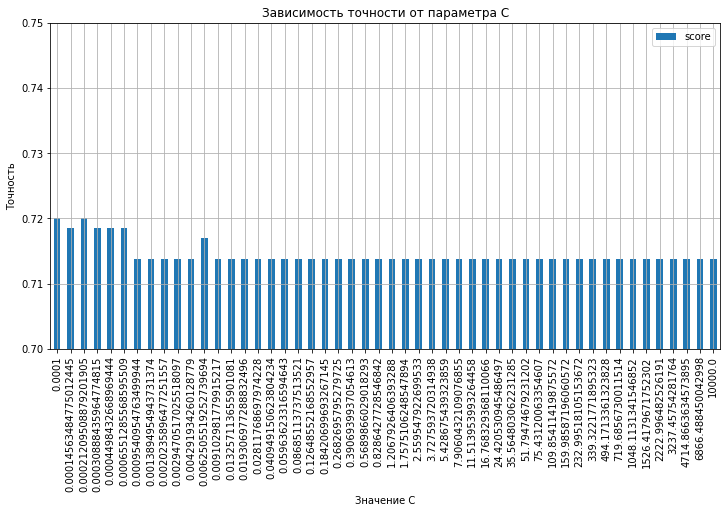

In [18]:
results.plot(kind='bar', y='score', x='number_C', ylim=[0.7,0.75], figsize=(12,6))
plt.title('Зависимость точности от параметра С')
plt.xlabel('Значение С')
plt.ylabel('Точность')
plt.grid()
plt.show()

Как видно из графика, данный алгоритм слабо подходит для данной задачи, так как никаким образом изменения гиперпараметра не влияет на точность предсказаний. Полученые значения меньше заданного порога в 0.75, поэтому не будем рассматривать данный алгоритм в дальнейшей работе.

### Наивный байесовский классификатор

\- Это простой вероятностный классификатор, основанный на применении теоремы Байеса со строгими (наивными) предположениями о независимости.

Так как признаки в таблицы непрерывные и скорее всего нормально распределены, то будет использовать модель **GaussianNB**. Скорый ручной перебор параметров не дал результата - изменения точности, поэтому используем модель по умолчанию.

In [19]:
gnb = GaussianNB()
gnb.fit(features_train, target_train)
result = gnb.score(features_valid, target_valid)

In [20]:
result

0.7791601866251944

Сохраним полученное значение, оно больше порогового значения. Посмотрим как покажет себя данный алгоритм на тестовой выборке.

In [21]:
result_df.loc[1]=['GaissianNB', result]

### Метод опорных векторов

Метод опорных векторов (англ. SVM, support vector machine) — набор схожих алгоритмов обучения с учителем, использующихся для задач классификации и регрессионного анализа. Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с наибольшим зазором в этом пространстве.

Рассмотрим последний алгоритм, для подбора лучших параметров воспользуемся встроенным методом поиска

In [22]:
C_array = np.logspace(-3, 3, num=7) #задаем диспазон значений параметра C
gamma_array = np.logspace(-5, 2, num=8) #задаем диспазон значений параметра gamma
svc = SVC(kernel='rbf', random_state=101)
grid = GridSearchCV(svc, param_grid={'C': C_array, 'gamma': gamma_array}, cv=10)
grid.fit(features_train, target_train)
print('Score       = ', grid.best_score_)
print('best C      = ', grid.best_estimator_.C)
print('best gamma  = ', grid.best_estimator_.gamma)

Score       =  0.7639923359240071
best C      =  1.0
best gamma  =  1e-05


Сохраним данное значение точности для для проверки на тестовой выборке.

In [23]:
result_df.loc[2]=['SVC', grid.best_score_]

### Вывод

В результате произведенных расчетов - увидили, как влияет изменение гиперпараметров на точность прогнозирования. До проверки моделей на тестовых данных выбрали три алгоритма.

In [24]:
result_df

,name_ml,accuracy_valid
0,RandomForest,0.810264
1,GaissianNB,0.779160
2,SVC,0.763992


## Проверка моделей на тестовой выборке

Теперь проверим наши модели на тестовой выборке, и построим график отображение сравнения точностей для разных моделей

In [25]:
accuracy_test = []

Случайный лес

In [26]:
randfor = RandomForestClassifier(random_state=101, n_estimators=10, criterion='entropy')
randfor.fit(features_train, target_train)
accuracy_test.append(randfor.score(features_test, target_test))

Наивный байесовский классификатор

In [27]:
gnb.fit(features_train, target_train)
accuracy_test.append(gnb.score(features_test, target_test))

Метод опорных векторов

In [28]:
accuracy_test.append(grid.best_estimator_.score(features_test, target_test))

Итоговая таблица результативности

In [29]:
result_df['accuracy_test'] = accuracy_test

In [30]:
result_df

,name_ml,accuracy_valid,accuracy_test
0,RandomForest,0.810264,0.793157
1,GaissianNB,0.779160,0.777605
2,SVC,0.763992,0.774495


Для наглядности построим график

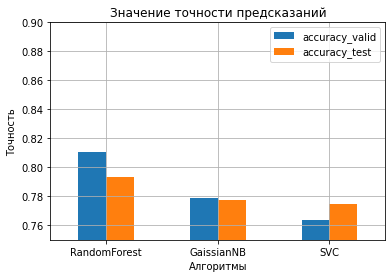

In [31]:
result_df.plot(kind='bar')
plt.title('Значение точности предсказаний')
plt.xlabel('Алгоритмы')
plt.ylabel('Точность')
plt.xticks(range(len(result_df['name_ml'])), labels=result_df['name_ml'], rotation=0)
plt.ylim(0.75,0.9)
plt.grid()
plt.show()

Как видно из таблицы и графика лучшую точность показывает алгоритм **Случайный лес**. В 79% он правильно предсказывает значение тарифа.

## Проверка на адекватность

Проверим полученные результаты с болванкой

In [32]:
dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
print('Точность болванки:', accuracy_score(target_test, dummy.predict(features_test)))

Точность болванки: 0.6811819595645412


## Вывод

В работе было рассмотрено 4 различных алгоритма машинного обучения, лучшим по метрике **accuracy** является RandomForest со значением **0,793** на тестовой выборке, что полностью удовлитворяет условиям задачи. Дополнительно было произведено сравнение полученых результатов с болванкой, чтобы показать, что обученные модели хорошо справляются с поставленной задачей.